# Macro architecture

## Ranker

- BM25
- Input: query string
- Output: list of top k doc_ids

## Reranker

- MonoT5 finetuned
- Input: list of `pygaggle.rerank.base.Text` objects
- Output: list of `pygaggle.rerank.base.Text` objects with the Score field updated

## Sentence selection

- MonoT5 finetuned
- Input: list of `pygaggle.rerank.base.Text` objects with sentences
- Output: list of `pygaggle.rerank.base.Text` objects with the Score field updated

## Classification

- T5 3B from scratch, must train on the dataset > training T5 3B is hard =(
- Input: `hypothesis: q sentence1: s1 ··· sentencez: sz`
- Output: one of `true`, `weak` or `false`

# Code

## Imports and installs

In [1]:
!git clone --recursive https://github.com/castorini/pygaggle.git

Cloning into 'pygaggle'...
remote: Enumerating objects: 1523, done.
remote: Counting objects: 100% (593/593), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 1523 (delta 500), reused 408 (delta 389), pack-reused 930
Receiving objects: 100% (1523/1523), 500.81 KiB | 2.69 MiB/s, done.
Resolving deltas: 100% (974/974), done.
Submodule 'tools' (https://github.com/castorini/anserini-tools.git) registered for path 'tools'
Cloning into '/content/pygaggle/tools'...
remote: Enumerating objects: 707, done.        
remote: Counting objects: 100% (464/464), done.        
remote: Compressing objects: 100% (405/405), done.        
remote: Total 707 (delta 68), reused 447 (delta 58), pack-reused 243        
Receiving objects: 100% (707/707), 57.74 MiB | 28.92 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Submodule path 'tools': checked out '808f48711b5e172da6aec8b1855518c8ea65489f'


In [2]:
%%capture
!pip install pygaggle pyserini torch faiss-cpu 

In [3]:
%%capture
!pip uninstall -y transformers
!pip install transformers

In [4]:
## Checking java version
## If not ok, follow instruction in https://github.com/castorini/pyserini/blob/master/docs/installation.md
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
!java --version

openjdk 11.0.17 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


In [167]:
import collections
import itertools
import functools
import toolz
import math
import random
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import copy

import scipy
import pandas as pd
import numpy as np

from google.colab import drive
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from typing import List, Type

In [6]:
import matplotlib.pyplot as plt

In [7]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [8]:
from pygaggle.rerank.base import Query, Text
from pygaggle.rerank.transformer import MonoT5
from pygaggle.rerank.base import hits_to_texts

from pyserini.search import SimpleSearcher as LuceneSearcher

In [9]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import Adafactor
# https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.Adafactor
# https://discuss.huggingface.co/t/t5-finetuning-tips/684/3

In [10]:
# Check which GPU we are using
!nvidia-smi

Wed Nov 30 15:41:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Configure environment

Download files, check video card and mount google drive

In [11]:
if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [12]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [13]:
# drive.mount('/content/drive')

In [14]:
!wget -nc https://scifact.s3-us-west-2.amazonaws.com/release/latest/data.tar.gz
!tar -xzf data.tar.gz

--2022-11-30 15:41:33--  https://scifact.s3-us-west-2.amazonaws.com/release/latest/data.tar.gz
Resolving scifact.s3-us-west-2.amazonaws.com (scifact.s3-us-west-2.amazonaws.com)... 52.92.132.42, 3.5.78.105, 52.92.146.66, ...
Connecting to scifact.s3-us-west-2.amazonaws.com (scifact.s3-us-west-2.amazonaws.com)|52.92.132.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3115079 (3.0M) [application/x-tar]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   2.97M  10.6MB/s    in 0.3s    

2022-11-30 15:41:33 (10.6 MB/s) - ‘data.tar.gz’ saved [3115079/3115079]



In [15]:
files_to_read = [
    "claims_dev",
    "claims_train",
    "claims_test",
    "corpus",
]

scifact_all = {}

for fname in files_to_read:
    scifact_all[fname] = []
    with open(f'data/{fname}.jsonl') as f:
        for line in f:
            scifact_all[fname].append(json.loads(line))

## Exploration on the dataset format

### Corpus

The corpus dataset have 5183 samples, and each sample has a:

* `doc_id` `Int`: unique identification
* `title` `String`: short description of what the text is about
* `abtract` `List[String]`: a list of paragraphs, which we are going to reference by index later on (position is important)
* `structured` `Bool`: boolean flag, although not sure what it means to be an "structured text"

In [16]:
len(scifact_all['corpus'])

5183

In [17]:
scifact_all['corpus'][0].keys()

dict_keys(['doc_id', 'title', 'abstract', 'structured'])

In [18]:
scifact_all['corpus'][0]

{'doc_id': 4983,
 'title': 'Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion tensor magnetic resonance imaging.',
 'abstract': ['Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities.',
  'A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7).',
  'To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term.',
  'In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms.',
  'In the posterior limb 

### Claims

* Training dataset have 809 observations
* Dev dataset have 300 observations
* Test dataset have 300 observations

Schema:

* `id` `Int`: unique identifier
* `claim` `String`: the claim we want to classify as true or false
* `evidence` `Dict[String, List[Dict]]`: very nested structure, it is a dictionary where each key is a document id, and each value is a list of sentences. Each sentence is a dictionary itself, with the list of sentences and the correspondent label
* `cited_doc_ids` `List[Int]`: list of document ids (from corpus) that have been cited in `evidence`

**Test dataset have only `id` and `claim`**

Questions:
* There is any evidence that have both a SUPPORT and a CONTRADICT label, simultaneously?

In [19]:
len(scifact_all['claims_train'])

809

In [20]:
len(scifact_all['claims_dev'])

300

In [21]:
len(scifact_all['claims_test'])

300

In [22]:
scifact_all['claims_train'][1]

{'id': 2,
 'claim': '1 in 5 million in UK have abnormal PrP positivity.',
 'evidence': {'13734012': [{'sentences': [4], 'label': 'CONTRADICT'}]},
 'cited_doc_ids': [13734012]}

In [23]:
scifact_all['claims_test'][0]

{'id': 7,
 'claim': '10-20% of people with severe mental disorder receive no treatment in low and middle income countries.'}

In [24]:
## Checking if there are evidences with both labels
for dataset_name in ['claims_train', 'claims_dev']:
    label_set_general = set()
    for claim in scifact_all[dataset_name]:
        label_set = set()
        for docid, evidences in claim['evidence'].items():
            for evidence in evidences:
                label_set.add(evidence['label'])
                label_set_general.add(evidence['label'])
        assert len(label_set) <= 1

In [25]:
label_set_general

{'CONTRADICT', 'SUPPORT'}

## Implement Abstract Retrieval with Pyserini

The format for creating indexes in pyserini is as a JSONL file with following fields:

```
{
  "id": "doc1",
  "contents": "this is the contents."
}
```

We are going to use the Text class from PyGaggle to convert the output of pyserini into a standardized format, because we are going to rescore these documents using this framework.

### Import Pyserini, format corpus and create indexes

In [26]:
try:
    os.mkdir('scifact_jsonl')
except FileExistsError:    
    print('Folder already exists')

In [27]:
## Prepare corpus dataset for pyserini indexer
with open('scifact_jsonl/corpus.jsonl', 'w') as f:
    for c in scifact_all['corpus']:
        new_json = {}
        new_json['id'] = c['doc_id']
        new_json['contents'] = ' '.join([c['title']] + c['abstract'])
        # new_json['contents'] = '. '.join(c['abstract'])
        new_json['title'] = c['title']
        f.write(json.dumps(new_json) + '\n')

In [28]:
!python -m pyserini.index -collection JsonCollection -generator DefaultLuceneDocumentGenerator \
 -threads 1 -input scifact_jsonl \
 -index indexes/scifact_jsonl -storePositions -storeDocvectors -storeRaw

2022-11-30 15:41:35,658 INFO  [main] index.IndexCollection (IndexCollection.java:650) - Setting log level to INFO
2022-11-30 15:41:35,661 INFO  [main] index.IndexCollection (IndexCollection.java:653) - Starting indexer...
2022-11-30 15:41:35,661 INFO  [main] index.IndexCollection (IndexCollection.java:654) - ============ Loading Parameters ============
2022-11-30 15:41:35,661 INFO  [main] index.IndexCollection (IndexCollection.java:655) - DocumentCollection path: scifact_jsonl
2022-11-30 15:41:35,661 INFO  [main] index.IndexCollection (IndexCollection.java:656) - CollectionClass: JsonCollection
2022-11-30 15:41:35,662 INFO  [main] index.IndexCollection (IndexCollection.java:657) - Generator: DefaultLuceneDocumentGenerator
2022-11-30 15:41:35,662 INFO  [main] index.IndexCollection (IndexCollection.java:658) - Threads: 1
2022-11-30 15:41:35,662 INFO  [main] index.IndexCollection (IndexCollection.java:659) - Stemmer: porter
2022-11-30 15:41:35,662 INFO  [main] index.IndexCollection (Index

In [29]:
searcher = LuceneSearcher('indexes/scifact_jsonl')

### Test example query

In [30]:
## Example
hits = searcher.search(
    '10% of sudden infant death syndrome (SIDS) deaths happen in newborns aged less than 6 months.',
    # remove_dups=True,
    # fields={'title': 2, 'contents': 1}
)
for i in range(len(hits)):
    print(f'{i+1} {hits[i].docid:4} {hits[i].score:.5f}')

1 2613775 23.29130
2 35521287 22.53440
3 23117378 22.21680
4 20240998 21.73400
5 21050357 16.48830
6 30292811 13.93470
7 19332616 12.19790
8 29253460 11.93430
9 24150328 11.28460
10 16204011 10.46450


In [31]:
[c for c in scifact_all['corpus'] if c['doc_id']==2613775]

[{'doc_id': 2613775,
  'title': 'Sudden infant death syndrome.',
  'abstract': ['Despite declines in prevalence during the past two decades, sudden infant death syndrome (SIDS) continues to be the leading cause of death for infants aged between 1 month and 1 year in developed countries.',
   'Behavioural risk factors identified in epidemiological studies include prone and side positions for infant sleep, smoke exposure, soft bedding and sleep surfaces, and overheating.',
   'Evidence also suggests that pacifier use at sleep time and room sharing without bed sharing are associated with decreased risk of SIDS.',
   'Although the cause of SIDS is unknown, immature cardiorespiratory autonomic control and failure of arousal responsiveness from sleep are important factors.',
   'Gene polymorphisms relating to serotonin transport and autonomic nervous system development might make affected infants more vulnerable to SIDS.',
   'Campaigns for risk reduction have helped to reduce SIDS incidence

### Evaluate performance on train data

In [32]:
expected_doc_ids = []
predicted_doc_ids = []
k=5

for i, claim in enumerate(scifact_all['claims_train']):
    if (i+1) % 100 == 0: print(f"Processing claim {i+1}")
    for doc_id in claim['cited_doc_ids']:
        expected_doc_ids.append({'id': int(claim['id']),
                                 'doc_id': int(doc_id)})
    
    hits = searcher.search(
        claim['claim'],
        k=50,
    )

    for h in hits[0:k]:
        predicted_doc_ids.append({
            'id': int(claim['id']),
            'doc_id': int(h.docid),
            'score': h.score
        })


expected_docs = pd.DataFrame(expected_doc_ids)
predicted_docs = pd.DataFrame(predicted_doc_ids)

results = expected_docs.merge(
    predicted_docs.set_index(['id', 'doc_id']).assign(predicted=1),
    on=['id', 'doc_id'],
    how='left'
).fillna(0)

r = results.groupby('id')['predicted'].agg(['sum', 'count'])
r['recall'] = r['sum'] / r['count']

r['recall'].mean()

Processing claim 100
Processing claim 200
Processing claim 300
Processing claim 400
Processing claim 500
Processing claim 600
Processing claim 700
Processing claim 800


0.7397816234033787

## Evaluation function

### Define test mocked examples

In [33]:
scifact_all['claims_dev'][0]

{'id': 1,
 'claim': '0-dimensional biomaterials show inductive properties.',
 'evidence': {},
 'cited_doc_ids': [31715818]}

In [34]:
test_golden_labels = [
    {
        "id": 52,
        "claim": "ALDH1 expression is associated with poorer prognosis for breast cancer primary tumors.",
        "evidence": {
            "11": [
                {"sentences": [ 0, 1 ], "label": "SUPPORT" },
                {"sentences": [ 11 ], "label": "SUPPORT" },
            ],
            "15": [
                {"sentences": [ 4 ], "label": "SUPPORT"},
            ]
        },
        "cited_doc_ids": [11, 15]
    }
]

In [35]:
test_predictions = [
    {
        "id": 52,
        "evidence": {
            "11": {
                "sentences": [1, 11, 13],
                "label": "SUPPORT"
            },
            "16": {
                "sentences": [18, 20],
                "label": "REFUTES"
            }
        }
    }
]

### Abstract metrics evaluation

In [36]:
def _f1_score(precision, recall):
    if precision != 0 and recall != 0:
        return 2 * precision * recall / (precision + recall)
    return 0

In [37]:
def flatten_gold_abstracts(gold_labels):
    flat_golden_labels = []
    for claim in gold_labels:
        for doc_id, sentence_list in claim['evidence'].items():
            for sentences in sentence_list:
                    new_row = {}
                    
                    new_row['id'] = claim['id']
                    new_row['doc_id'] = doc_id
                    new_row['label'] = sentences['label']
                    new_row['sentence'] = set(sentences['sentences'])
                    
                    flat_golden_labels.append(new_row)
    
    return pd.DataFrame(flat_golden_labels)


def flatten_predicted_abstracts(predictions):
    flat_predictions = []
    
    for prediction in predictions:
        for doc_id, evidence in prediction['evidence'].items():
            new_row = {}    
            
            new_row['id'] = prediction['id']
            new_row['doc_id'] = doc_id
            new_row['label'] = evidence['label']
            new_row['sentence'] = set(evidence['sentences'][:3]) # top 3 only
            # new_row['sentence'] = set(evidence['sentences']) # take all

            flat_predictions.append(new_row)
    
    return pd.DataFrame(flat_predictions)

In [38]:
def eval_abstracts(gold_labels, predictions):
    df_gold_labels = flatten_gold_abstracts(gold_labels)
    df_predictions = flatten_predicted_abstracts(predictions)
    
    df_eval = df_gold_labels \
        .join(
            df_predictions.reset_index().set_index(['id', 'doc_id']),
            on=['id', 'doc_id'],
            lsuffix='_gold',
            rsuffix='_pred',
            how='outer'
        )

    def _add_sentence_correctness(row):
        if row['sentence_gold'] is not np.nan and row['sentence_pred'] is not np.nan:
            return row['sentence_gold'].issubset(row['sentence_pred'])
        return False
    
    df_eval['gold_is_subset'] = df_eval.apply(_add_sentence_correctness, axis=1)
    df_eval['label_is_correct'] = df_eval['label_gold'] == df_eval['label_pred']
    df_eval['gold_and_label_correct'] = df_eval['gold_is_subset'] & df_eval['label_is_correct']

    df_eval['is_gold'] = df_eval['label_gold'].notna()
    df_eval['is_pred'] = df_eval['label_pred'].notna()

    def _abstract_correctness(df):
        return pd.Series({
            'correct_label_only': df['label_is_correct'].any(),
            'correct_label_rationale': df['gold_and_label_correct'].any(),
            'is_gold': df['is_gold'].any(),
            'is_pred': df['is_pred'].any(),
        })

    return df_eval.groupby(['id', 'doc_id']).apply(_abstract_correctness)


def abstract_metrics(gold_labels, predictions):
    ret = {}
    df = eval_abstracts(gold_labels, predictions).sum()

    ret['label__precision'] = df['correct_label_only'] / df['is_pred']
    ret['label__recall'] = df['correct_label_only'] / df['is_gold']
    ret['label__f1'] = _f1_score(ret['label__precision'], ret['label__recall'])
    
    ret['label_rationale__precision'] = df['correct_label_rationale'] / df['is_pred']
    ret['label_rationale__recall'] = df['correct_label_rationale'] / df['is_gold']
    ret['label_rationale__f1'] = _f1_score(ret['label_rationale__precision'], ret['label_rationale__recall'])
        
    return ret

### Sentence metrics evaluation

In [39]:
def flatten_gold_sentences(gold_labels):
    flat_golden_labels = []
    for claim in gold_labels:
        for doc_id, sentence_list in claim['evidence'].items():
            for i, sentences in enumerate(sentence_list):
                for sentence in sentences['sentences']:
                    new_row = {}
                    
                    new_row['id'] = claim['id']
                    new_row['doc_id'] = doc_id
                    new_row['sentence_set'] = i
                    new_row['label'] = sentences['label']
                    new_row['sentence'] = sentence
                    
                    flat_golden_labels.append(new_row)
    
    return pd.DataFrame(flat_golden_labels)


def flatten_predicted_sentences(predictions):
    flat_predictions = []
    
    for prediction in predictions:
        for doc_id, evidence in prediction['evidence'].items():
            for sentence in evidence['sentences']:
                new_row = {}    
                
                new_row['id'] = prediction['id']
                new_row['doc_id'] = doc_id
                new_row['label'] = evidence['label']
                new_row['sentence'] = sentence

                flat_predictions.append(new_row)
        
    return pd.DataFrame(flat_predictions)

In [40]:
def eval_sentences(gold_labels, predictions):
    df_gold_labels = flatten_gold_sentences(gold_labels)
    df_predictions = flatten_predicted_sentences(predictions)
    
    df_eval = df_gold_labels \
        .join(
            df_predictions.reset_index().set_index(['id', 'doc_id', 'sentence']),
            on=['id', 'doc_id', 'sentence'],
            lsuffix='_gold',
            rsuffix='_pred',
            how='outer'
        )

    df_eval['is_gold'] = df_eval['label_gold'].notna()
    df_eval['is_pred'] = df_eval['label_pred'].notna()
    
    df_eval['correct_select_naive'] = df_eval['is_pred'] & df_eval['is_gold']
    df_sentence_set = df_eval.groupby(['id', 'doc_id', 'sentence_set'])['correct_select_naive'].all()
    df_eval = df_eval.join(
        df_sentence_set.rename('sentence_set_correct'),
        on=['id', 'doc_id', 'sentence_set'],
        how='left'
    )

    df_eval['correct_select'] = (df_eval['correct_select_naive'] 
                                   & df_eval['sentence_set_correct']
                                   & (df_eval['label_pred'] != "NOINFO"))
    df_eval['correct_select_label'] = (df_eval['label_gold'] == df_eval['label_pred']) & df_eval['correct_select']
    
    df_eval = df_eval.set_index(['id', 'doc_id', 'sentence']).sort_index()
    return_cols = ['correct_select_label', 'correct_select', 'is_gold', 'is_pred']

    return df_eval[return_cols]


def sentences_metrics(gold_labels, predictions):
    ret = {}
    df = eval_sentences(gold_labels, predictions).sum()

    ret['select__precision'] = df['correct_select'] / df['is_pred']
    ret['select__recall'] = df['correct_select'] / df['is_gold']
    ret['select__f1'] = _f1_score(ret['select__precision'], ret['select__recall'])
    
    ret['select_label__precision'] = df['correct_select_label'] / df['is_pred']
    ret['select_label__recall'] = df['correct_select_label'] / df['is_gold']
    ret['select_label__f1'] = _f1_score(ret['select_label__precision'], ret['select_label__recall'])
    
    
    return ret

### Test evaluation functions

In [41]:
eval_abstracts(test_golden_labels, test_predictions)

correct_label_only  correct_label_rationale  is_gold  is_pred
id doc_id                                                               
52 11                    True                     True     True     True
   15                   False                    False     True    False
   16                   False                    False    False     True

In [42]:
abstract_metrics(test_golden_labels, test_predictions)

{'label__precision': 0.5,
 'label__recall': 0.5,
 'label__f1': 0.5,
 'label_rationale__precision': 0.5,
 'label_rationale__recall': 0.5,
 'label_rationale__f1': 0.5}

In [43]:
eval_sentences(test_golden_labels, test_predictions)

correct_select_label  correct_select  is_gold  is_pred
id doc_id sentence                                                        
52 11     0                        False           False     True    False
          1                        False           False     True     True
          11                        True            True     True     True
          13                       False           False    False     True
   15     4                        False           False     True    False
   16     18                       False           False    False     True
          20                       False           False    False     True

In [44]:
sentences_metrics(test_golden_labels, test_predictions)

{'select__precision': 0.2,
 'select__recall': 0.25,
 'select__f1': 0.22222222222222224,
 'select_label__precision': 0.2,
 'select_label__recall': 0.25,
 'select_label__f1': 0.22222222222222224}

## Implement ranking & reranking with BM25 & monoT5 (pretrained on Marco)

### Classes and functions

In [45]:
class Ranker:
    def __init__(self, bm25, k):
        self.bm25 = bm25
        self.k = k
    
    def rank(self, claim) -> Text:
        q = claim['claim']
        hits = self.bm25.search(q, k=self.k)
        return hits_to_texts(hits), Query(q)


class Reranker:
    def __init__(self, ranker: Ranker, monot5, k):
        self.ranker = ranker
        self.monot5 = monot5
        self.k = k
    
    def rank(self, claim) -> Text:
        ranking, query = self.ranker.rank(claim)
        reranked = self.monot5.rerank(query, ranking)
        
        trunc_reranked = sorted(reranked, key=lambda x: x.score, reverse=True)[:self.k]

        return trunc_reranked, query

In [46]:
def display_text_list(texts):
    for i in range(0, len(texts)):
        print(f'{i+1:2} {texts[i].metadata["docid"]:15} {texts[i].score:.5f} {texts[i].text}')

In [47]:
scifact_all['claims_train'][1]

{'id': 2,
 'claim': '1 in 5 million in UK have abnormal PrP positivity.',
 'evidence': {'13734012': [{'sentences': [4], 'label': 'CONTRADICT'}]},
 'cited_doc_ids': [13734012]}

In [48]:
def evaluate_ranking_recall(claims_dataset, ranker, relevant_only=True):
    expected_doc_ids = []
    predicted_doc_ids = []

    for i, claim in enumerate(tqdm(claims_dataset)):
        if relevant_only:
            doc_id_list = claim['evidence'].keys()
        else:
            doc_id_list = claim['cited_doc_ids']

        for doc_id in doc_id_list:
            expected_doc_ids.append({'id': int(claim['id']), 'doc_id': int(doc_id)})
        
        ranking, query = ranker.rank(claim)

        for row in ranking:
             predicted_doc_ids.append({
                'id': int(claim['id']),
                'doc_id': int(row.metadata["docid"]),
                'score': row.score
            })
             
    expected_docs = pd.DataFrame(expected_doc_ids)
    predicted_docs = pd.DataFrame(predicted_doc_ids)

    results = expected_docs.merge(
        predicted_docs.set_index(['id', 'doc_id']).assign(predicted=1),
        on=['id', 'doc_id'],
        how='left'
    ).fillna(0)

    r = results.groupby('id')['predicted'].agg(['sum', 'count'])
    r['recall'] = r['sum'] / r['count']

    # return r['recall'].mean()
    return results['predicted'].sum() / results['predicted'].count()

### Evaluate BM25 ranker for different k

In [49]:
evaluate_ranking_recall(scifact_all['claims_train'], Ranker(searcher, k=30))

0.9645390070921985

In [50]:
evaluate_ranking_recall(scifact_all['claims_train'], Ranker(searcher, k=20))

0.9556737588652482

In [51]:
evaluate_ranking_recall(scifact_all['claims_train'], Ranker(searcher, k=10))

0.9379432624113475

In [52]:
evaluate_ranking_recall(scifact_all['claims_train'], Ranker(searcher, k=5))

0.8812056737588653

In [53]:
evaluate_ranking_recall(scifact_all['claims_train'], Ranker(searcher, k=3))

0.8191489361702128

### Create and evaluate reranker

In [54]:
t5_reranking =  MonoT5()

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [55]:
reranker_k5 = Reranker(Ranker(searcher, k=20), t5_reranking, k=5)
reranker_k3 = Reranker(Ranker(searcher, k=20), t5_reranking, k=3)

In [56]:
# reranker_k3.rank(scifact_all['claims_train'][0])

In [57]:
evaluate_ranking_recall(scifact_all['claims_dev'], reranker_k5)

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:220: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated"


0.8851674641148325

In [58]:
evaluate_ranking_recall(scifact_all['claims_dev'], reranker_k3)

0.8564593301435407

## T5 evaluation and finetuning functions

In [59]:
def evaluate_model(model, data_loader):
    eval_loss = []
    with torch.no_grad():
        for data in data_loader:
            input = data[0].to(device)
            input_mask = data[1].to(device)
            target = data[2].to(device)
            target_mask = data[3].to(device)

            loss = model(input_ids=input, attention_mask=input_mask, 
                         decoder_attention_mask=target_mask, labels=target).loss
            eval_loss.append(loss.item())

    return np.mean(eval_loss)


def finetune_t5_label(
    model,
    train_data_loader,
    valid_data_loader,
    optimizer,
    epochs,
    batches_per_backward
):

    train_losses = []
    valid_losses = []
    optimizer.zero_grad()
    acc_batch = 0
    DEBUG = False
    def dprint(f):
        if DEBUG: print(f'  DEBUG: {f}')

    epoch_tqdm = tqdm(range(epochs))
    for e in epoch_tqdm:
        batch_tqdm = tqdm(train_data_loader)
        batch_train_loss = []
        for train_ in batch_tqdm:
            
            dprint("send input data to device")
            input = train_[0].to(device)
            input_mask = train_[1].to(device)
            target = train_[2].to(device)
            target_mask = train_[3].to(device)

            dprint("forward pass")
            loss = model(input_ids=input, attention_mask=input_mask,
                         decoder_attention_mask=target_mask, labels=target).loss
            acc_batch += 1
            
            if acc_batch % batches_per_backward == 0:
                dprint("backward pass + optimizer step")
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            batch_tqdm.set_description(f'   Train loss: {np.mean(batch_train_loss)}')
            batch_train_loss.append(loss.item())
        
        train_losses.append(np.mean(batch_train_loss))
        valid_losses.append(evaluate_model(model, valid_data_loader))
        epoch_tqdm.set_description(f'Valid loss: {valid_losses[-1]:.4f}, Train loss: {train_losses[-1]:.4f}')
    
    return train_losses, valid_losses


## Implement Sentence Selection

We need to fine tune a monoT5 for sentence selection.

Task: predict "true" or "false""

Need to create:
- Input examples: sentences that are relevant from golden rationale;
- Output tokens;
- Fine tuning function;

"true" examples > get gold rationales from ground truth

"false" examples > get random sentences from important documents

In [60]:
def find_corpus_by_doc_id(doc_id, corpus=scifact_all['corpus']):
    return [c for c in corpus if c['doc_id']==int(doc_id)][0]

In [61]:
## Implement TF-IDF for creating a better senetence selection training datset

from sklearn.feature_extraction.text import TfidfVectorizer

import string
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def preprocess_tfidf(text):
    return text.lower().translate(remove_punctuation_map)

def tokenize_tfidf(text):
    return nltk.word_tokenize(preprocess_tfidf(text))

sw = [preprocess_tfidf(text) for text in stopwords.words('english')]
vectorizer = TfidfVectorizer(tokenizer=tokenize_tfidf, stop_words=sw)

def compute_similarity(a, b):
    tfidf = vectorizer.fit_transform([a, b])
    return ((tfidf * tfidf.T).toarray())[0,1]
  
# def weighted_sample_without_replacement(population, weights, k, rng=random):
#     v = [rng.random() ** (1 / (w + 0.00001)) for w in weights]
#     order = sorted(range(len(population)), key=lambda i: v[i])
#     return [population[i] for i in order[-k:]]

def sample_similar_sentences(claim, abstract, k):
    weights = [compute_similarity(s, claim) for s in abstract]
    return random.choices(abstract, weights=weights, k=k)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [62]:
def build_train_dataset_sentence_select(p, claims, with_cited_docs=True, rnd_num=5):
    
    true_sentences = []
    false_sentences = []

    for claim in claims:
        
        for doc_id, evidence_set in claim['evidence'].items():
            doc = find_corpus_by_doc_id(doc_id)
            
            true_senteces_temp = []
            false_sentences_temp = []
            
            # process true important sentences
            for sentence_set in evidence_set:
                for sentence_id in sentence_set['sentences']:
                    true_sentence = doc['abstract'][sentence_id]
                    true_sentences.append([claim['claim'], true_sentence])
                    true_senteces_temp.append(true_sentence)
                
                for sentence_id, sentence in enumerate(doc['abstract']):
                    if not sentence_id in sentence_set['sentences']:
                        false_sentences_temp.append(sentence)

            # create false examples (not important)
            num_random_sentences = random.randint(1, rnd_num) # randomized number of examples
            false_examples = sample_similar_sentences(
                  claim['claim'], false_sentences_temp, num_random_sentences) # examples should be convincing
            
            for e in false_examples:
                if e not in true_senteces_temp:
                    false_sentences.append([claim['claim'], e]) # examples should not be in true sentences

        if with_cited_docs and len(claim['evidence']) == 0:
            for doc_id in claim['cited_doc_ids']:
                doc = find_corpus_by_doc_id(doc_id)

                num_random_sentences = random.randint(1, rnd_num)
                false_examples = sample_similar_sentences(
                      claim['claim'], doc['abstract'], num_random_sentences) # examples should be convincing
                
                for e in false_examples:
                    false_sentences.append([claim['claim'], e]) # examples should not be in true sentences

    return true_sentences, false_sentences


def sentence_selection_pattern(true_sentences, false_sentences):
    pattern = 'Query: {query} Document: {document} Relevant:'
    dataset = []

    for s in true_sentences:
        dataset.append([
            pattern.format(query=s[0], document=s[1]),
            "true"
        ])

    for s in false_sentences:
        dataset.append([
            pattern.format(query=s[0], document=s[1]),
            "false"
        ])
    random.shuffle(dataset)
    return dataset

In [63]:
trues_dev, falses_dev = build_train_dataset_sentence_select(1, scifact_all['claims_dev'], rnd_num=3)
sentences_dev = sentence_selection_pattern(trues_dev, falses_dev)

print(len(trues_dev), len(falses_dev))

366 582


In [64]:
trues_train, falses_train = build_train_dataset_sentence_select(1, scifact_all['claims_train'], rnd_num=3)
sentences_train = sentence_selection_pattern(trues_train, falses_train)

print(len(trues_train), len(falses_train))

1025 1623


In [65]:
trues_train[0]

['1 in 5 million in UK have abnormal PrP positivity.',
 'RESULTS Of the 32,441 appendix samples 16 were positive for abnormal PrP, indicating an overall prevalence of 493 per million population (95% confidence interval 282 to 801 per million).']

In [66]:
sentences_train[3]

['Query: Pseudoknots are not evolutionarily conserved in most eukaryotes. Document: Both of the RNAs have a highly conserved helical region, P4, which is important in the catalytic reaction. Relevant:',
 'false']

In [67]:
class T5SentenceDataset(Dataset):
    def __init__(self, dataset, tokenizer, source_max_length, target_max_length):
        
        self.original_source = [i[0] for i in dataset]
        self.original_target = [i[1] for i in dataset]

        source = tokenizer(self.original_source, padding='max_length', truncation=True, max_length=source_max_length, return_tensors="pt")
        target = tokenizer(self.original_target, padding=True,  truncation=True, max_length=target_max_length, return_tensors="pt")
        
        self.source_token_ids, self.source_attention_mask = source['input_ids'], source['attention_mask']
        self.target_token_ids, self.target_attention_mask = target['input_ids'], target['attention_mask']

        self.target_token_ids[self.target_token_ids == tokenizer.pad_token_id] = -100

        
    def __len__(self):
        return len(self.original_source)


    def __getitem__(self, idx):
        return (self.source_token_ids[idx],
                self.source_attention_mask[idx],
                self.target_token_ids[idx],
                self.target_attention_mask[idx],
                self.original_source[idx],
                self.original_target[idx])


### Create model, finetune T5

In [68]:
# t5_sentence = MonoT5()
t5_sentence = MonoT5(
    model = T5ForConditionalGeneration.from_pretrained('castorini/monot5-large-msmarco').to(device)
)

In [69]:
## check device used
next(t5_sentence.model.parameters(), None).device

device(type='cuda', index=0)

In [70]:
t5_sentence_model = t5_sentence.model
tokenizer_sentence = t5_sentence.tokenizer.tokenizer

In [71]:
### Hyperparameters

max_source_length_sentence = 512
max_target_length_sentence = 2
batch_size_sentence = 4
batches_per_backward_sentence = 32

learning_rate_sentence = 3e-5
epochs_num_sentence = 12

In [72]:
sentence_train_dataset = T5SentenceDataset(sentences_train, tokenizer_sentence, max_source_length_sentence, max_target_length_sentence)
sentence_dev_dataset = T5SentenceDataset(sentences_dev, tokenizer_sentence, max_source_length_sentence, max_target_length_sentence)

sentence_dataloader_train = DataLoader(sentence_train_dataset, batch_size=batch_size_sentence, shuffle=True, num_workers=0)
sentence_dataloader_dev = DataLoader(sentence_dev_dataset, batch_size=batch_size_sentence, shuffle=False, num_workers=0)

In [73]:
len(sentence_train_dataset), len(sentence_dev_dataset)

(2648, 948)

In [74]:
optimizer_sentence = Adafactor(t5_sentence_model.parameters(), lr=learning_rate_sentence, relative_step=False, scale_parameter=False)
criterion_sentence = torch.nn.CrossEntropyLoss()

In [75]:
# evaluate_model(t5_sentence_model, sentence_dataloader_train)

In [76]:
# evaluate_model(t5_sentence_model, sentence_dataloader_dev)

In [77]:
pd.Series([r[5] for r in sentence_train_dataset]).value_counts()

false    1623
true     1025
dtype: int64

In [78]:
pd.Series([r[5] for r in sentence_dev_dataset]).value_counts()

false    582
true     366
dtype: int64

In [79]:
train_losses_sequence, valid_losses_sequence = [], []

In [80]:
for i in range(epochs_num_sentence):
    t, v = finetune_t5_label(
        t5_sentence_model,
        sentence_dataloader_train,
        sentence_dataloader_dev,
        optimizer_sentence,
        1,
        batches_per_backward_sentence
    )
    train_losses_sequence.append(t)
    valid_losses_sequence.append(v)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [81]:
print(
    max_source_length_sentence,
    max_target_length_sentence,
    batch_size_sentence,
    batches_per_backward_sentence,
    learning_rate_sentence,
    epochs_num_sentence,
)

512 2 4 32 3e-05 12


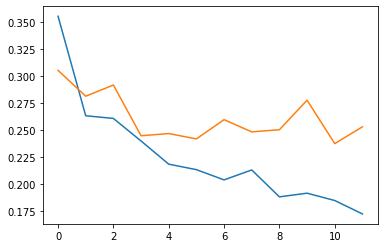

In [168]:
plt.plot(train_losses_sequence)
plt.plot(valid_losses_sequence)
plt.show()

In [83]:
valid_losses_sequence

[[0.30517994282366356],
 [0.2812746242003099],
 [0.29161757540413596],
 [0.2447496776818789],
 [0.24677539696987671],
 [0.24182854694184625],
 [0.2596106004286243],
 [0.2483356319906245],
 [0.25030144329088494],
 [0.27761051852751195],
 [0.23747460880485768],
 [0.2530180474051632]]

In [84]:
tokenizer_true_id = tokenizer_sentence("true", return_tensors="pt").input_ids[0][0].item()
tokenizer_false_id = tokenizer_sentence("false", return_tensors="pt").input_ids[0][0].item()

token_map_sentence = {
    tokenizer_true_id: 'true',
    tokenizer_false_id: 'false',
}

In [85]:
# do_sample
# max_new_tokens

In [86]:
# def _decode_logits(model, input_ids, attention_mask, decoder_attention_mask, labels)

def greedy_decode_logits(model, dataloader, tokens_list=[6136, 1176]):

    logits_list = []

    for data in dataloader:

        input = data[0].to(device)
        input_mask = data[1].to(device)
        # target = data[2].to(device)
        # target_mask = data[3].to(device)
        num_ex = input.shape[0]
        decoder_input_ids = torch.zeros([num_ex], dtype=int).reshape(-1,1).to(device)

        logits = model(input_ids=input, 
                       attention_mask=input_mask,
                       decoder_input_ids=decoder_input_ids,
                       ).logits

        # logits = model(input_ids=input, attention_mask=input_mask,
        #                decoder_attention_mask=target_mask, labels=target).logits
        
        scores = logits[:,0,tokens_list]
        scores = torch.nn.functional.log_softmax(scores, dim=1)
        scores = scores.cpu().detach().numpy()

        logits_list.append(scores)

    return np.concatenate(logits_list)

In [1320]:
def model_prediction_report(model, dataloader, token_id_map):
    
    preds = []
    expecteds = []

    for data in dataloader:
        gen = model.generate(
            data[0].to(device),
            attention_mask=data[1].to(device),
            max_length=3
        )

        pred = gen[:, 1].cpu().detach().numpy()
        pred = np.array([token_id_map.get(p, 'invalid') for p in pred])

        preds.append(pred)
        expecteds.append(np.array(data[5]))
    
    preds = np.concatenate(preds)
    expecteds = np.concatenate(expecteds)
    labels = list(token_id_map.values())

    return classification_report(expecteds, preds, labels=labels, digits=4), expecteds, preds, labels

# cfr, trues, preds, labels = model_prediction_report(t5_sentence_model, sentence_dataloader_dev, 0.2)
# print(cfr)

In [1316]:
def report_performance(expected, logits, threshold):
    preds = ['true' if l > np.log(threshold) else 'false' for l in logits[:,1]]

    labels=['true','false']

    return classification_report(expected, preds, labels=['true','false'], digits=4)

In [89]:
logits_pred = greedy_decode_logits(t5_sentence_model, sentence_dataloader_dev)

In [1317]:
print(report_performance(sentence_dev_dataset[:][5], logits_pred, 0.24))

              precision    recall  f1-score   support

        true     0.7686    0.7623    0.7654       366
       false     0.8513    0.8557    0.8535       582

    accuracy                         0.8196       948
   macro avg     0.8099    0.8090    0.8095       948
weighted avg     0.8194    0.8196    0.8195       948



## Implement Classification (Label Prediction)

### Create training dataset

In [91]:
label_map = {
    'SUPPORT': "true",
    "CONTRADICT": "false",
    "NOINFO": "weak"
}

In [92]:
def gold_evidence_preprocess(claim, corpus=scifact_all['corpus']):
    
    sentences_text = []
    labels = []
    doc_set = claim['evidence']

    # if there is actual evidence
    if len(doc_set) > 0:
        for doc_id, evidence_set in doc_set.items():
            doc = find_corpus_by_doc_id(doc_id)
            for sentence_set in evidence_set:
                labels.append(sentence_set['label'])
                for sentence_id in sentence_set['sentences']:
                    sentences_text.append(doc['abstract'][sentence_id])
    
    # if there is no actual evidence, create weak evidence from cited_doc_ids
    else:
        for cited_doc_id in claim['cited_doc_ids']:
            doc = find_corpus_by_doc_id(cited_doc_id)
            num_sentences = random.randint(1, 2) # select between 1 and 2 sentences
            sentences = sample_similar_sentences(claim['claim'], doc['abstract'], num_sentences)
            sentences_text += list(set(sentences))
            labels.append("NOINFO")

    return sentences_text, labels


def label_classification_pattern(claim, corpus=scifact_all['corpus']):
    # "hypothesis: {q} sentence1: s1 · · · sentencez: sz"

    sentences_text, labels = gold_evidence_preprocess(claim, corpus)
    
    input_raw = f"hypothesis: {claim['claim']}"
    for i, sentence in enumerate(sentences_text):
        input_raw += f" sentence{i+1}: {sentence}"
    
    output_raw = label_map[labels[0]]

    return input_raw, output_raw

In [93]:
label_classification_pattern(scifact_all['claims_train'][2])

('hypothesis: 1-1% of colorectal cancer patients are diagnosed with regional or distant metastases. sentence1: During the study period, 44,924 eligible patients were diagnosed with colorectal cancer. sentence2: Among the patients with cancer, stage was classified as early (stage I) vs all other (stages II-IV).',
 'weak')

In [94]:
label_classification_pattern(scifact_all['claims_dev'][0])

('hypothesis: 0-dimensional biomaterials show inductive properties. sentence1: We further discuss their utility and the potential concerns regarding their cytotoxicity.',
 'weak')

### Train new T5 model

In [95]:
## Global configs

# label_prediction_t5_model_size = "t5-3b"

label_prediction_t5_model_size = "t5-large"
epochs_num = 28 + 4 + 2
learning_rate = 1e-5

# label_prediction_t5_model_size = "t5-small"
# learning_rate = 1e-4
# epochs_num = 12

max_source_length = 512
max_target_length = 4
batch_size = 4
batches_per_backward = 32

In [96]:
tokenizer = T5Tokenizer.from_pretrained(label_prediction_t5_model_size)

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [97]:
## Defining for later: token id for our 3 labels
tokenizer_true_id = tokenizer("true", return_tensors="pt").input_ids[0][0].item()
tokenizer_false_id = tokenizer("false", return_tensors="pt").input_ids[0][0].item()
tokenizer_weak_id = tokenizer("weak", return_tensors="pt").input_ids[0][0].item()

print(tokenizer_true_id, tokenizer_false_id, tokenizer_weak_id)

token_map_classification = {
    tokenizer_true_id: 'true',
    tokenizer_false_id: 'false',
    tokenizer_weak_id: 'weak',
}

1176 6136 5676


#### Create dataset and dataloader

In [98]:
class T5LabelDataset(Dataset):
    def __init__(self, claims, is_training, preprocessor, tokenizer, source_max_length, target_max_length):

        text_pairs = [label_classification_pattern(c) for c in claims]
        if is_training:
            self.original_source = []
            self.original_target = []
            for i in text_pairs:
                self.original_source.append(i[0])
                self.original_target.append(i[1])
                if (i[1] == 'false' and random.random() < 0.60) or (i[1] == 'weak' and random.random() < 0.05):
                    for j in range(random.randint(1,2)):
                        self.original_source.append(i[0])
                        self.original_target.append(i[1])
        else:
            self.original_source = [i[0] for i in text_pairs]
            self.original_target = [i[1] for i in text_pairs]

        source = tokenizer(self.original_source, padding='max_length', truncation=True, max_length=source_max_length, return_tensors="pt")
        target = tokenizer(self.original_target, padding=True,  truncation=True, max_length=target_max_length, return_tensors="pt")
        
        self.source_token_ids, self.source_attention_mask = source['input_ids'], source['attention_mask']
        self.target_token_ids, self.target_attention_mask = target['input_ids'], target['attention_mask']

        self.target_token_ids[self.target_token_ids == tokenizer.pad_token_id] = -100

        
    def __len__(self):
        return len(self.original_source)


    def __getitem__(self, idx):
        return (self.source_token_ids[idx],
                self.source_attention_mask[idx],
                self.target_token_ids[idx],
                self.target_attention_mask[idx],
                self.original_source[idx],
                self.original_target[idx])


In [99]:
dataset_train = T5LabelDataset(scifact_all['claims_train'], True, label_classification_pattern, tokenizer,
                               max_source_length, max_target_length)
dataset_dev = T5LabelDataset(scifact_all['claims_dev'], False, label_classification_pattern, tokenizer,
                             max_source_length, max_target_length)

In [100]:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_dev = DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, num_workers=0)

In [101]:
pd.Series(dataset_train[:][5]).value_counts()

weak     333
true     332
false    325
dtype: int64

In [102]:
pd.Series(dataset_dev[:][5]).value_counts()

true     124
weak     112
false     64
dtype: int64

#### Create T5 and fine tune

In [103]:
t5_label_prediction = T5ForConditionalGeneration.from_pretrained(label_prediction_t5_model_size).to(device)

In [104]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adafactor(
    t5_label_prediction.parameters(),
    lr=learning_rate,
    relative_step=False, scale_parameter=False
)

In [105]:
train_losses, valid_losses = [], []

In [160]:
for epoch in range(2):
    t, v = finetune_t5_label(
        t5_label_prediction,
        dataloader_train,
        dataloader_dev,
        optimizer,
        1,
        batches_per_backward
    )
    train_losses.append(t)
    valid_losses.append(v)

In [161]:
print(
    label_prediction_t5_model_size,
    epochs_num,
    learning_rate,
    max_source_length,
    max_target_length,
    batch_size,
    batches_per_backward,
)

t5-large 28 1e-05 512 4 4 32


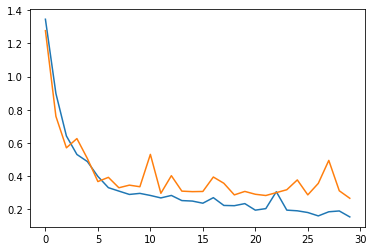

In [169]:
plt.plot(train_losses[4:])
plt.plot(valid_losses[4:])
plt.show()

In [163]:
valid_losses 

[[3.4731133651733397],
 [2.5123916800816852],
 [2.063545613288879],
 [1.6195113023122152],
 [1.2770465767383576],
 [0.7594567443927129],
 [0.5693286126852035],
 [0.6251794336239497],
 [0.5043288761377335],
 [0.36550245255231856],
 [0.3910218752920628],
 [0.3280787469943364],
 [0.3438807885348797],
 [0.3342651296158632],
 [0.5296927074591319],
 [0.29466601183017094],
 [0.4009848623474439],
 [0.30763894411424797],
 [0.304647785735627],
 [0.30569897932931783],
 [0.39298139438033103],
 [0.3552166886876027],
 [0.2850217661323647],
 [0.30596134334802627],
 [0.2887713224813342],
 [0.2812422614917159],
 [0.29863379801313084],
 [0.316176548935473],
 [0.3754575698201855],
 [0.2851411816353599],
 [0.35458853097011644],
 [0.49336349047875655],
 [0.30975346468389037],
 [0.2645735313805441]]

In [1321]:
cfr, trues, preds, labels = model_prediction_report(t5_label_prediction, dataloader_dev, token_map_classification)

In [1322]:
print(cfr)

              precision    recall  f1-score   support

        true     0.8862    0.8790    0.8826       124
        weak     0.8654    0.8036    0.8333       112
       false     0.6986    0.7969    0.7445        64

    accuracy                         0.8333       300
   macro avg     0.8167    0.8265    0.8201       300
weighted avg     0.8384    0.8333    0.8347       300



In [1311]:
token_map_classification = {
    tokenizer_true_id: 'true',
    
    tokenizer_weak_id: 'weak',
    tokenizer_false_id: 'false',
}

In [1313]:
print(cfr)

              precision    recall  f1-score   support

        true       0.89      0.88      0.88       124
        weak       0.87      0.80      0.83       112
       false       0.70      0.80      0.74        64

    accuracy                           0.83       300
   macro avg       0.82      0.83      0.82       300
weighted avg       0.84      0.83      0.83       300



In [1310]:
print(cfr)

              precision    recall  f1-score   support

        true       0.89      0.88      0.88       124
       false       0.70      0.80      0.74        64
        weak       0.87      0.80      0.83       112

    accuracy                           0.83       300
   macro avg       0.82      0.83      0.82       300
weighted avg       0.84      0.83      0.83       300



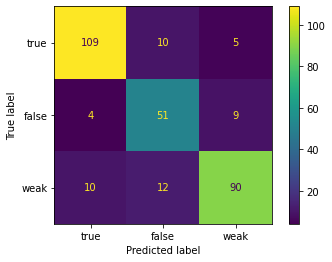

In [172]:
ConfusionMatrixDisplay(
    confusion_matrix(trues, preds, labels=labels),
    display_labels=labels
).plot()

## Complete pipeline, final model

In [173]:
# break

In [174]:
scifact_all['claims_train'][0]

{'id': 0,
 'claim': '0-dimensional biomaterials lack inductive properties.',
 'evidence': {},
 'cited_doc_ids': [31715818]}

### Designed pipeline

#### Input

```
[
	{
		"id": 52,
		"claim": "blablabla",
        **other_keys
	}
]
```

#### Abstract retrieval >>> implementar solução "oracle" também

```
[
	{
		"id": 52,
		"claim": "blablabla",
		"evidence": ["11", "44", "55"]
	}
]
```

## Sentence selection (scoring)

```
[
    {
        "id": 52,
        "claim": "blablabla",
        "evidence": {
            "11": {
                "sentences": {1: 0.88, 2: 0.90, ... 13: 0.99},
            },
            "16": {
                "sentences": {1: 0.77, 2: 0.76, ... 18: 0.96, 20: 0.98},
            }
        }
    }
]
```

## Sentence selection (thresholding)

```
[
    {
        "id": 52,
        "claim": "blablabla",
        "evidence": {
            "11": {
                "sentences": [1, 11, 13],
            },
            "16": {
                "sentences": [18, 20],
            }
        }
    }
]
```


## Label classification

```
[
    {
        "id": 52,
        "claim": "blablabla",
        "evidence": {
            "11": {
                "sentences": [1, 11, 13],
                "label": "SUPPORT"
            },
            "16": {
                "sentences": [18, 20],
                "label": "REFUTES"
            }
        }
    }
]
```

### Implementation

#### Abstract Retrieval

In [243]:
scifact_all['claims_train'][1]

{'id': 2,
 'claim': '1 in 5 million in UK have abnormal PrP positivity.',
 'evidence': {'13734012': [{'sentences': [4], 'label': 'CONTRADICT'}]},
 'cited_doc_ids': [13734012]}

In [244]:
class StepAbstractRetrieval:
    def __init__(self, ranker=None, oracle=False):

        if (ranker is None) and (oracle==False):
            raise Exception("Ranker should be defined if not an Oracle")
        elif (ranker is not None) and (oracle==True):
            raise Exception("If oracle is True, ranker cannot be defined")

        self.oracle = oracle
        self.ranker = ranker

    
    def __call__(self, inputs):
 
        output_list = []

        for input in inputs:
            output = {}
            output['id'] = input['id']
            output['claim'] = input['claim']

            if self.oracle:
                output['evidence'] = list(input['evidence'].keys())
            else:
                ranking, _ = self.ranker.rank(input)
                output['evidence'] = [t.metadata['docid'] for t in ranking]
            
            output_list.append(output)
        
        return output_list

In [245]:
step_abstract_retrieval_t5 = StepAbstractRetrieval(ranker=reranker_k3)
step_abstract_retrieval_bm25 = StepAbstractRetrieval(ranker=Ranker(searcher, k=3))
step_abstract_retrieval_oracle = StepAbstractRetrieval(oracle=True)

In [246]:
output_ex1 = step_abstract_retrieval_bm25(scifact_all['claims_train'])
print(len(output_ex1))
output_ex1[:3]

809


[{'id': 0,
  'claim': '0-dimensional biomaterials lack inductive properties.',
  'evidence': ['10608397', '14827874', '26071782']},
 {'id': 2,
  'claim': '1 in 5 million in UK have abnormal PrP positivity.',
  'evidence': ['13734012', '18617259', '4828631']},
 {'id': 4,
  'claim': '1-1% of colorectal cancer patients are diagnosed with regional or distant metastases.',
  'evidence': ['1387104', '24980622', '10958594']}]

In [247]:
output_ex2 = step_abstract_retrieval_oracle(scifact_all['claims_train'])
print(len(output_ex2))
output_ex2[:3]

809


[{'id': 0,
  'claim': '0-dimensional biomaterials lack inductive properties.',
  'evidence': []},
 {'id': 2,
  'claim': '1 in 5 million in UK have abnormal PrP positivity.',
  'evidence': ['13734012']},
 {'id': 4,
  'claim': '1-1% of colorectal cancer patients are diagnosed with regional or distant metastases.',
  'evidence': []}]

#### Sentence selection (scoring)

In [248]:
class StepSentenceSelectionScoring:
    def __init__(self, monot5):
        self.monot5 = monot5


    def __call__(self, inputs):
        output_list = []

        for input in inputs:
            output = {}

            output['id'] = input['id']
            output['claim'] = input['claim']
            
            output['evidence'] = {}
            for doc_id in input['evidence']:
                corpus = find_corpus_by_doc_id(doc_id)
                
                sentences_ranked = self.monot5.rerank(
                    Query(output['claim']), 
                    [ Text(a, {'sentence_id': id}, 0) for (id, a) in enumerate(corpus['abstract'])]
                )

                sentences_scored = { t.metadata['sentence_id']: t.score for t in sentences_ranked }

                output['evidence'][doc_id] = {'sentences': sentences_scored}
            
            output_list.append(output)

        return output_list


In [249]:
step_sentence_selection_scoring = StepSentenceSelectionScoring(t5_sentence)

In [250]:
ex_output_scoring = step_sentence_selection_scoring(output_ex1[1:2])

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:220: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated"


In [251]:
ex_output_scoring

[{'id': 2,
  'claim': '1 in 5 million in UK have abnormal PrP positivity.',
  'evidence': {'13734012': {'sentences': {0: -5.9396891593933105,
     1: -7.502349376678467,
     2: -6.474424839019775,
     3: -5.915549278259277,
     4: -0.9743689298629761,
     5: -2.784499406814575,
     6: -4.017050266265869,
     7: -2.5930826663970947,
     8: -6.706538200378418}},
   '18617259': {'sentences': {0: -7.7884111404418945,
     1: -5.021060943603516,
     2: -5.677096366882324,
     3: -5.411457538604736,
     4: -5.721450328826904}},
   '4828631': {'sentences': {0: -7.6132354736328125,
     1: -7.948862552642822,
     2: -7.797823429107666,
     3: -7.317359447479248,
     4: -3.5189504623413086,
     5: -7.389981746673584,
     6: -5.570540428161621,
     7: -5.204188346862793,
     8: -6.343135833740234,
     9: -6.567677021026611,
     10: -7.039429187774658,
     11: -5.18418550491333,
     12: -7.590523719787598,
     13: -6.610432147979736,
     14: -7.581872463226318}}}}]

#### Sentence selection (thresholding)

In [252]:
class StepSentenceSelectionThresholding:
    def __init__(self, threshold):
        self.threshold = threshold
    
    def transform(self, input):
        output = {}
        output['id'] = input['id']
        output['claim'] = input['claim']
        output['evidence'] = {}
        for doc_id, evidence in input['evidence'].items():
            sentences_scored = evidence['sentences']
            sentences_filtered = [
                s for s, score in sentences_scored.items() 
                if score >= self.threshold
            ]

            if len(sentences_filtered) > 0:
                output['evidence'][doc_id] = {'sentences': sentences_filtered}

        return output

    def __call__(self, inputs):
        return [
            self.transform(input)
            for input in inputs
        ]


In [253]:
step_sentence_selection_th = StepSentenceSelectionThresholding(-1)

In [254]:
ex_output_sentence_selec = step_sentence_selection_th(ex_output_scoring)
ex_output_sentence_selec

[{'id': 2,
  'claim': '1 in 5 million in UK have abnormal PrP positivity.',
  'evidence': {'13734012': {'sentences': [4]}}}]

#### Label classification

In [255]:
token_map_step_label = {
    tokenizer_true_id: 'SUPPORT',
    tokenizer_false_id: 'CONTRADICT',
    tokenizer_weak_id: 'NOINFO',
}

In [256]:
class StepLabelClassification:
    def __init__(self, t5model, tokenizer, source_max_length, token_id_map):
        self.t5model = t5model
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.token_id_map = token_id_map
    

    def get_sentences_text(self, doc_id, sentence_id_list):
        doc = find_corpus_by_doc_id(doc_id)
        return [
            doc['abstract'][sentence_id]
            for sentence_id in sentence_id_list
        ]
    
    def get_query_text(self, claim, sentences_text):
        input_raw = f"hypothesis: {claim}"
        for i, sentence in enumerate(sentences_text):
            input_raw += f" sentence{i+1}: {sentence}"
        return input_raw


    def _tokenize(self, query):
        tks = self.tokenizer(
            query, padding='max_length', truncation=True,
            max_length=self.source_max_length, return_tensors="pt"
        )
        return tks['input_ids'], tks['attention_mask']


    def transform(self, input):
        output = {}
        output['id'] = input['id']
        output['claim'] = input['claim']
        output['evidence'] = {}
        
        for doc_id, evidences in input['evidence'].items():
            sentences = evidences['sentences']
            sentences_text = self.get_sentences_text(doc_id, sentences)
            
            q = [self.get_query_text(claim, sentences_text)]
            input_ids, attention_mask = self._tokenize(q)

            gen = self.t5model.generate(
                input_ids.to(device),
                attention_mask=attention_mask.to(device),
                max_length=3
            )

            pred = gen[:, 1].cpu().detach().numpy()
            pred = np.array([self.token_id_map.get(p, 'NOINFO') for p in pred])
            pred = pred.item()

            if pred != 'NOINFO':
                output['evidence'][doc_id] = {
                    'sentences': sentences,
                    'label': pred
                }
        
        return output


    def __call__(self, inputs):
        return [
            self.transform(input)
            for input in inputs
        ]

In [257]:
class StepLabelClassification02:
    def __init__(self, t5model, tokenizer, source_max_length, token_id_map):
        self.t5model = t5model
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.token_id_map = token_id_map

    def get_sentences_text(self, doc_id, sentence_id_list):
        doc = find_corpus_by_doc_id(doc_id)
        return [
            doc['abstract'][sentence_id]
            for sentence_id in sentence_id_list
        ]
    
    def get_query_text(self, claim, sentences_text):
        input_raw = f"hypothesis: {claim}"
        for i, sentence in enumerate(sentences_text):
            input_raw += f" sentence{i+1}: {sentence}"
        return input_raw


    def _tokenize(self, query):
        tks = self.tokenizer(
            query, padding='max_length', truncation=True,
            max_length=self.source_max_length, return_tensors="pt"
        )
        return tks['input_ids'], tks['attention_mask']


    def transform(self, input):
        output = {}
        output['id'] = input['id']
        output['claim'] = input['claim']
        output['evidence'] = {}

        tokens_list = [tokenizer_true_id, tokenizer_false_id, tokenizer_weak_id]
        
        for doc_id, evidences in input['evidence'].items():
            sentences = evidences['sentences']
            sentences_text = self.get_sentences_text(doc_id, sentences)
            
            q = [self.get_query_text(claim, sentences_text)]
            input_ids, attention_mask = self._tokenize(q)
            
            num_ex = input_ids.shape[0]
            decoder_input_ids = torch.zeros([num_ex], dtype=int).reshape(-1,1)

            logits = self.t5model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                decoder_input_ids=decoder_input_ids.to(device)
            ).logits

            scores = logits[:,0,tokens_list]
            scores = torch.nn.functional.log_softmax(scores, dim=1)
            scores = scores.cpu().detach().numpy()

            output['evidence'][doc_id] = {
                'sentences': sentences,
                'label_scores': scores
            }
        
        return output


    def __call__(self, inputs):
        return [
            self.transform(input)
            for input in inputs
        ]

In [477]:
class LabelFinal:
    def __init__(self, weights):
        self.w = weights
        self.label_list = ['SUPPORT', 'CONTRADICT', 'NOINFO']

    def transform(self, input):

        output = {}
        output['id'] = input['id']
        output['claim'] = input['claim']
        output['evidence'] = {}
        output['noinfo_evidence'] = {}

        for doc_id, evidence in input['evidence'].items():
            scores = copy.deepcopy(evidence['label_scores'].ravel())

            for i in range(len(scores)):
                scores[i] = scores[i] + self.w[i]

            pred_id = np.argmax(scores)
            pred = self.label_list[pred_id]
            
            if pred == 'NOINFO':
                evidence_output_name = "noinfo_evidence"
            else:
                evidence_output_name = "evidence"

            output[evidence_output_name][doc_id] = {
                'sentences': evidence['sentences'],
                'label': pred,
                'label_softmax': scipy.special.softmax(scores)
            }

        return output

    def __call__(self, inputs):
        return [
            self.transform(input)
            for input in inputs
        ]

In [258]:
step_label_classification = StepLabelClassification(
    t5_label_prediction,
    tokenizer,
    max_source_length, 
    token_map_step_label
)

In [259]:
step_label_classification(ex_output_sentence_selec)

[{'id': 2,
  'claim': '1 in 5 million in UK have abnormal PrP positivity.',
  'evidence': {'13734012': {'sentences': [4], 'label': 'CONTRADICT'}}}]

In [260]:
token_map_step_label

{1176: 'SUPPORT', 6136: 'CONTRADICT', 5676: 'NOINFO'}

In [261]:
step_label_classification_02 = StepLabelClassification02(
    t5_label_prediction,
    tokenizer,
    max_source_length, 
    token_map_step_label
)

In [262]:
step_label_classification_02(ex_output_sentence_selec)

[{'id': 2,
  'claim': '1 in 5 million in UK have abnormal PrP positivity.',
  'evidence': {'13734012': {'sentences': [4],
    'label_scores': array([[-2.1829815 , -0.17148027, -3.1038055 ]], dtype=float32)}}}]

### Run full pipeline

In [263]:
# break

#### Fine-tune sentence selection

In [264]:
first_half_pipeline = toolz.compose(
  StepSentenceSelectionScoring(t5_sentence),
  StepAbstractRetrieval(ranker=Reranker(Ranker(searcher, k=20), t5_reranking, k=3))
)

In [265]:
first_half_oracle = toolz.compose(
  StepSentenceSelectionScoring(t5_sentence),
  StepAbstractRetrieval(oracle=True)
)

second_half_pipeline = toolz.compose(
  step_label_classification,
  StepSentenceSelectionThresholding(-0.06)
)

In [266]:
claims_train_input = [
    {'id': d['id'], 'claim': d['claim']} for d in scifact_all['claims_train']
]

claims_dev_input = [
    {'id': d['id'], 'claim': d['claim']} for d in scifact_all['claims_dev']
]

In [267]:
first_half_dev = first_half_pipeline(scifact_all['claims_dev'])

In [268]:
scifact_all['claims_dev'][2:5]

[{'id': 5,
  'claim': '1/2000 in UK have abnormal PrP positivity.',
  'evidence': {'13734012': [{'sentences': [4], 'label': 'SUPPORT'}]},
  'cited_doc_ids': [13734012]},
 {'id': 13,
  'claim': '5% of perinatal mortality is due to low birth weight.',
  'evidence': {},
  'cited_doc_ids': [1606628]},
 {'id': 36,
  'claim': 'A deficiency of vitamin B12 increases blood levels of homocysteine.',
  'evidence': {},
  'cited_doc_ids': [5152028, 11705328]}]

In [269]:
len(first_half_dev)

300

In [270]:
def agg_confusion(df):
    return df.groupby(['is_gold', 'is_pred']).size().unstack(1)

def f1_q(df):
    tp = df['is_gold'] & df['is_pred']
    fp = (~df['is_gold']) & df['is_pred']
    fn = df['is_gold'] & (~df['is_pred'])

    tp = tp.sum()
    fp = fp.sum()
    fn = fn.sum()

    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (prec * recall) / (prec + recall)
    return prec, recall, f1

In [325]:
first_half_dev[1]

{'id': 3,
 'claim': '1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.',
 'evidence': {'14717500': {'sentences': {0: -4.103703498840332,
    1: -4.84822416305542,
    2: -2.9818620681762695,
    3: -6.231766223907471,
    4: -4.788154602050781,
    5: -4.7479448318481445,
    6: -2.8253183364868164,
    7: -3.225734233856201}},
  '4378885': {'sentences': {0: -6.4671311378479,
    1: -5.611166477203369,
    2: -5.9701714515686035,
    3: -3.407482385635376,
    4: -3.3068594932556152,
    5: -4.690845489501953,
    6: -4.090459823608398}},
  '2739854': {'sentences': {0: -5.215965270996094,
    1: -2.2738897800445557,
    2: -6.793994426727295}}}}

In [272]:
np.log(0.50), np.log(0.80), np.log(0.94), np.log(0.99)

(-0.6931471805599453,
 -0.22314355131420968,
 -0.06187540371808753,
 -0.01005033585350145)

In [295]:
th_selection = StepSentenceSelectionThresholding(-1)(first_half_dev)

In [296]:
for d in th_selection:
    for d2 in d['evidence'].values():
        if 'sentences' in d2.keys():
            d2['label'] = 'NOINFO'

In [506]:
agg_confusion(eval_abstracts(scifact_all['claims_dev'], th_selection))

is_pred,False,True
is_gold,,
False,NaN,188.0
True,52.0,157.0


In [298]:
f1_q(eval_abstracts(scifact_all['claims_dev'], th_selection))

(0.45507246376811594, 0.7511961722488039, 0.5667870036101084)

In [299]:
agg_confusion(eval_sentences(scifact_all['claims_dev'], th_selection))

is_pred,False,True
is_gold,,
False,NaN,567.0
True,131.0,235.0


In [300]:
f1_q(eval_sentences(scifact_all['claims_dev'], th_selection))

(0.29301745635910226, 0.6420765027322405, 0.4023972602739726)

#### Last step

In [352]:
scenarios = [
    -0.1,
    -0.25,
    -1
]

In [302]:
full_pred_0 = step_label_classification(StepSentenceSelectionThresholding(scenarios[0])(first_half_dev))

In [303]:
abstract_metrics(scifact_all['claims_dev'], full_pred_0)

{'label__precision': 0.23333333333333334,
 'label__recall': 0.06698564593301436,
 'label__f1': 0.10408921933085502,
 'label_rationale__precision': 0.18333333333333332,
 'label_rationale__recall': 0.05263157894736842,
 'label_rationale__f1': 0.08178438661710037}

In [304]:
sentences_metrics(scifact_all['claims_dev'], full_pred_0)

{'select__precision': 0.6382978723404256,
 'select__recall': 0.16393442622950818,
 'select__f1': 0.2608695652173913,
 'select_label__precision': 0.1702127659574468,
 'select_label__recall': 0.04371584699453552,
 'select_label__f1': 0.06956521739130435}

In [305]:
full_pred_1 = step_label_classification(StepSentenceSelectionThresholding(scenarios[1])(first_half_dev))

In [306]:
abstract_metrics(scifact_all['claims_dev'], full_pred_1)

{'label__precision': 0.1773049645390071,
 'label__recall': 0.11961722488038277,
 'label__f1': 0.14285714285714285,
 'label_rationale__precision': 0.14893617021276595,
 'label_rationale__recall': 0.10047846889952153,
 'label_rationale__f1': 0.12}

In [307]:
sentences_metrics(scifact_all['claims_dev'], full_pred_1)

{'select__precision': 0.5169491525423728,
 'select__recall': 0.3333333333333333,
 'select__f1': 0.4053156146179402,
 'select_label__precision': 0.13983050847457626,
 'select_label__recall': 0.09016393442622951,
 'select_label__f1': 0.1096345514950166}

In [353]:
full_pred_2 = step_label_classification(StepSentenceSelectionThresholding(scenarios[2])(first_half_dev))

In [354]:
abstract_metrics(scifact_all['claims_dev'], full_pred_2)

{'label__precision': 0.13851351351351351,
 'label__recall': 0.19617224880382775,
 'label__f1': 0.16237623762376235,
 'label_rationale__precision': 0.10810810810810811,
 'label_rationale__recall': 0.15311004784688995,
 'label_rationale__f1': 0.12673267326732673}

In [355]:
sentences_metrics(scifact_all['claims_dev'], full_pred_2)

{'select__precision': 0.28924418604651164,
 'select__recall': 0.5437158469945356,
 'select__f1': 0.37760910815939286,
 'select_label__precision': 0.09302325581395349,
 'select_label__recall': 0.17486338797814208,
 'select_label__f1': 0.12144212523719165}

### Full pipeline, second try

#### Apply abstract retrieval

In [494]:
abstract_retrieval = toolz.compose(
  StepSentenceSelectionScoring(t5_sentence),
  StepAbstractRetrieval(ranker=Reranker(Ranker(searcher, k=20), t5_reranking, k=3)),
)

abstract_retrieval_oracle = toolz.compose(
  StepSentenceSelectionScoring(t5_sentence),
  StepAbstractRetrieval(oracle=True)
)

In [480]:
dev_abstract_retrieval = abstract_retrieval(scifact_all['claims_dev'])

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:220: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated"


In [481]:
dev_abstract_retrieval_oracle = abstract_retrieval_oracle(scifact_all['claims_dev'])

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:220: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated"


#### Apply sentence selection and label

In [1289]:
# -1.0
# 0, -4, 0

In [1290]:
label_scoring_pipeline = toolz.compose(
    step_label_classification_02,
    StepSentenceSelectionThresholding(-0.4)
)

In [1291]:
dev_pred_scoring = label_scoring_pipeline(dev_abstract_retrieval)

In [1292]:
dev_pred_scoring_oracle = label_scoring_pipeline(dev_abstract_retrieval_oracle)

#### Final labeling

In [1293]:
labels_w = [0, -2.5, -3]

final_label = LabelFinal(labels_w)

dev_pred_label = final_label(dev_pred_scoring)
dev_pred_label_oracle = final_label(dev_pred_scoring_oracle)

In [1294]:
am = abstract_metrics(scifact_all['claims_dev'], dev_pred_label)
am

{'label__precision': 0.37,
 'label__recall': 0.35406698564593303,
 'label__f1': 0.36185819070904646,
 'label_rationale__precision': 0.305,
 'label_rationale__recall': 0.291866028708134,
 'label_rationale__f1': 0.29828850855745725}

In [1295]:
sm = sentences_metrics(scifact_all['claims_dev'], dev_pred_label)
sm

{'select__precision': 0.42178770949720673,
 'select__recall': 0.412568306010929,
 'select__f1': 0.4171270718232044,
 'select_label__precision': 0.25139664804469275,
 'select_label__recall': 0.2459016393442623,
 'select_label__f1': 0.24861878453038674}

In [1296]:
t = eval_abstract_selection(scifact_all['claims_dev'], dev_pred_label)
t['label_pred'].fillna("NOINFO", inplace=True)
t['label_gold'].fillna("NOINFO", inplace=True)
print(classification_report(t['label_gold'], t['label_pred']))

              precision    recall  f1-score   support

  CONTRADICT       0.28      0.27      0.28       122
      NOINFO       0.00      0.00      0.00        81
     SUPPORT       0.55      0.44      0.48       216

    accuracy                           0.30       419
   macro avg       0.28      0.24      0.25       419
weighted avg       0.36      0.30      0.33       419



In [1297]:
"""
-0.1 > 0.28874734607218683
-0.4 > 0.4216216216216216
-0.5 > 0.4203980099502488
-0.7 > 0.40421052631578946
-1.0 > 0.386986301369863
-2.0 > 0.28329809725158567
"""

'\n-0.1 > 0.28874734607218683\n-0.4 > 0.4216216216216216\n-0.5 > 0.4203980099502488\n-0.7 > 0.40421052631578946\n-1.0 > 0.386986301369863\n-2.0 > 0.28329809725158567\n'

#### Oracle

In [1300]:
am = abstract_metrics(scifact_all['claims_dev'], dev_pred_label_oracle)
am

{'label__precision': 0.5909090909090909,
 'label__recall': 0.37320574162679426,
 'label__f1': 0.4574780058651026,
 'label_rationale__precision': 0.49242424242424243,
 'label_rationale__recall': 0.31100478468899523,
 'label_rationale__f1': 0.38123167155425225}

In [1301]:
sm = sentences_metrics(scifact_all['claims_dev'], dev_pred_label_oracle)
sm

{'select__precision': 0.6482213438735178,
 'select__recall': 0.44808743169398907,
 'select__f1': 0.529886914378029,
 'select_label__precision': 0.3715415019762846,
 'select_label__recall': 0.2568306010928962,
 'select_label__f1': 0.3037156704361874}

In [1314]:
t = eval_abstract_selection(scifact_all['claims_dev'], dev_pred_label_oracle)
t['label_pred'].fillna("NOINFO", inplace=True)
t['label_gold'].fillna("NOINFO", inplace=True)
print(classification_report(t['label_gold'], t['label_pred']))

              precision    recall  f1-score   support

  CONTRADICT       0.39      0.32      0.35       122
      NOINFO       0.00      0.00      0.00         0
     SUPPORT       0.73      0.45      0.56       216

    accuracy                           0.40       338
   macro avg       0.37      0.26      0.30       338
weighted avg       0.61      0.40      0.48       338



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Grid search params

In [1080]:
selection_th_list = [-0.4, -1.0, -2.0]
labels_w_list = [
    [0,0,0],
    [0,-2,0],
    [0,-3,0],
    [0,0,-1],
    [0,0,-2],
    [0,-2,-1],
    [0,-3,-1],
    [0,-2,-2],
    [0,-3,-2],
]
break
exps = []

for th in selection_th_list:
    for w in labels_w_list:
        print(th, w)
        
        label_scoring_pipeline = toolz.compose(
            step_label_classification_02,
            StepSentenceSelectionThresholding(th))
        
        final_label = LabelFinal(w)
        
        dev_pred_scoring = label_scoring_pipeline(dev_abstract_retrieval)
        dev_pred_label = final_label(dev_pred_scoring)

        am = abstract_metrics(scifact_all['claims_dev'], dev_pred_label)
        sm = sentences_metrics(scifact_all['claims_dev'], dev_pred_label)

        exps.append({
            'th': th,
            'w': w,
            'am': am,
            'sm': sm
            })

-0.4 [0, 0, 0]
-0.4 [0, -2, 0]
-0.4 [0, -3, 0]
-0.4 [0, 0, -1]
-0.4 [0, 0, -2]
-0.4 [0, -2, -1]
-0.4 [0, -3, -1]
-0.4 [0, -2, -2]
-0.4 [0, -3, -2]
-1.0 [0, 0, 0]
-1.0 [0, -2, 0]
-1.0 [0, -3, 0]
-1.0 [0, 0, -1]
-1.0 [0, 0, -2]
-1.0 [0, -2, -1]
-1.0 [0, -3, -1]
-1.0 [0, -2, -2]
-1.0 [0, -3, -2]
-2.0 [0, 0, 0]
-2.0 [0, -2, 0]
-2.0 [0, -3, 0]
-2.0 [0, 0, -1]
-2.0 [0, 0, -2]
-2.0 [0, -2, -1]
-2.0 [0, -3, -1]
-2.0 [0, -2, -2]
-2.0 [0, -3, -2]


In [1082]:
# backup = copy.deepcopy(exps)

In [ ]:
exps

In [1083]:
formatted = []
for exp in exps:
    formatted.append({
        'th': exp['th'],
        'w': exp['w'],
        'label_rationale__f1': exp['am']['label_rationale__f1'],
        'select_label__f1': exp['sm']['select_label__f1'],
    })
  
formatted = pd.DataFrame(formatted)

In [1085]:
formatted.sort_values('select_label__f1', ascending=False)

,th,w,label_rationale__f1,select_label__f1
8,-0.4,"[0, -3, -2]",0.304569,0.246734
17,-1.0,"[0, -3, -2]",0.266393,0.226415
6,-0.4,"[0, -3, -1]",0.279570,0.222576
15,-1.0,"[0, -3, -1]",0.234483,0.208431
11,-1.0,"[0, -3, 0]",0.205263,0.174286
2,-0.4,"[0, -3, 0]",0.235294,0.166052
26,-2.0,"[0, -3, -2]",0.202946,0.157460
7,-0.4,"[0, -2, -2]",0.179104,0.155367
16,-1.0,"[0, -2, -2]",0.177515,0.154863
5,-0.4,"[0, -2, -1]",0.176166,0.152239


#### Performance

In [990]:
# flatten_predicted_abstracts(dev_pred_label)

In [991]:
# flatten_gold_abstracts(scifact_all['claims_dev'])

In [992]:
def eval_abstract_selection(gold_labels, predictions):
    df_gold_labels = flatten_gold_abstracts(gold_labels)
    df_predictions = flatten_predicted_abstracts(predictions)
    
    df_eval = df_gold_labels \
        .join(
            df_predictions.reset_index(drop=True).set_index(['id', 'doc_id']),
            on=['id', 'doc_id'],
            lsuffix='_gold',
            rsuffix='_pred',
            how='outer'
        )

    def _add_sentence_correctness(row):
        if row['sentence_gold'] is not np.nan and row['sentence_pred'] is not np.nan:
            return row['sentence_gold'].issubset(row['sentence_pred'])
        return False
    
    df_eval['gold_is_subset'] = df_eval.apply(_add_sentence_correctness, axis=1)
    df_eval['label_is_correct'] = df_eval['label_gold'] == df_eval['label_pred']
    df_eval['gold_and_label_correct'] = df_eval['gold_is_subset'] & df_eval['label_is_correct']

    df_eval['is_gold'] = df_eval['label_gold'].notna()
    df_eval['is_pred'] = df_eval['label_pred'].notna()

    def _abstract_correctness(df):
        return pd.Series({
            'correct_label_only': df['label_is_correct'].any(),
            'correct_label_rationale': df['gold_and_label_correct'].any(),
            'is_gold': df['is_gold'].any(),
            'is_pred': df['is_pred'].any(),
        })

    return df_eval
    # return df_eval.groupby(['id', 'doc_id']).apply(_abstract_correctness)


In [1162]:
t = eval_abstract_selection(scifact_all['claims_dev'], dev_pred_label)
t['label_pred'].fillna("NOINFO", inplace=True)
t['label_gold'].fillna("NOINFO", inplace=True)
print(classification_report(t['label_gold'], t['label_pred']))

              precision    recall  f1-score   support

  CONTRADICT       0.18      0.10      0.13       122
      NOINFO       0.00      0.00      0.00        75
     SUPPORT       0.48      0.44      0.46       216

    accuracy                           0.26       413
   macro avg       0.22      0.18      0.20       413
weighted avg       0.30      0.26      0.28       413



In [1149]:
print(classification_report(t['label_gold'], t['label_pred']))

              precision    recall  f1-score   support

  CONTRADICT       0.28      0.08      0.13       122
      NOINFO       0.00      0.00      0.00        75
     SUPPORT       0.49      0.52      0.50       216

    accuracy                           0.30       413
   macro avg       0.25      0.20      0.21       413
weighted avg       0.34      0.30      0.30       413



In [472]:
full_pred_correct = LabelFinal([0,-3,0])(full_pred_x)

In [473]:
full_pred_correct[:3]

[{'id': 1,
  'claim': '0-dimensional biomaterials show inductive properties.',
  'evidence': {},
  'noinfo_evidence': {}},
 {'id': 3,
  'claim': '1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.',
  'evidence': {},
  'noinfo_evidence': {}},
 {'id': 5,
  'claim': '1/2000 in UK have abnormal PrP positivity.',
  'evidence': {},
  'noinfo_evidence': {'13734012': {'sentences': [4, 7],
    'label': 'NOINFO',
    'label_softmax': array([0.02684684, 0.00723093, 0.9659223 ], dtype=float32)}}}]

In [471]:
scifact_all['claims_dev'][:3]

[{'id': 1,
  'claim': '0-dimensional biomaterials show inductive properties.',
  'evidence': {},
  'cited_doc_ids': [31715818]},
 {'id': 3,
  'claim': '1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.',
  'evidence': {'14717500': [{'sentences': [2, 5], 'label': 'SUPPORT'},
    {'sentences': [7], 'label': 'SUPPORT'}]},
  'cited_doc_ids': [14717500]},
 {'id': 5,
  'claim': '1/2000 in UK have abnormal PrP positivity.',
  'evidence': {'13734012': [{'sentences': [4], 'label': 'SUPPORT'}]},
  'cited_doc_ids': [13734012]}]